
# RUN THIS FIRST

In [50]:
import pandas as pd
import numpy as np
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from functions import sample_mean
from lists import stop_words,noise
from plots import model_plots
import string
import warnings
import os
import pickle
import matplotlib.pyplot as plt

%matplotlib inline


def lower_rm_punct(review):
    return np.asarray([wrd.lower() for wrd in ''.join([wrd for\
                                                       wrd in review if wrd not in punctuation]).split()])

def my_padding(review,maxlen,dictionary):
    seq = np.zeros(maxlen).astype(str)
    if len(review) > maxlen:
        for i in range(maxlen):
            seq[i] = review[i]
    else:
        for i in range(1,len(review)+1):
            seq[-i] = review[-i]
    return np.asarray([str(0) if wrd not in dictionary else str(dictionary[wrd]) for wrd in seq]).astype(int)

def transform(review,maxlen,dictionary):
    clean_review = lower_rm_punct(review)
    return my_padding(clean_review,maxlen,dictionary)

punctuation = set(string.punctuation)
file = 'word_dict_ta.pickle'
os.chdir('/home/ubuntu/Notebooks/capstone/models')
with open(file, 'rb') as f:
    word_dict = pickle.load(f)
os.chdir('/home/ubuntu/Notebooks/data')
model = load_model('first_model_ta2.h5')

# Ta Test

### Train DATA

In [2]:
ta_data = pd.read_pickle('ta/ta_data2.pickle').replace(1.0,2.0).replace(0.0,2.0).\
                                                    sample(frac=.5,random_state=3)
ta_data.columns = ['index', 'id', 'offering_id', 'text', 'ratings_overall', 'language']
ta_data = ta_data[ta_data['language'] == 'en']
ta_data['ratings_overall'].value_counts()

idx_2 = ta_data[ta_data['ratings_overall'] == 2].index
idx_3 = ta_data[ta_data['ratings_overall'] == 3].index
idx_4 = ta_data[ta_data['ratings_overall'] == 4].index
idx_5 = ta_data[ta_data['ratings_overall'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=12937)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=12937)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=12937)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=12937)
ta_data = pd.concat([ta_data.loc[sample_idx_2],
           ta_data.loc[sample_idx_3],
           ta_data.loc[sample_idx_4],
           ta_data.loc[sample_idx_5]],axis=0)

In [14]:
df = pd.read_pickle('/home/ubuntu/Notebooks/data/ta/ta_data2.pickle')
train_idx = ta_data.index.values
test_idx = [i for i in df.index if i not in train_idx]
df = df.loc[test_idx].replace(1.0,2.0).replace(0.0,2.0)
df.columns = ['index', 'id', 'offering_id', 'text', 'stars', 'language']
df = df[df['language'] == 'en']
df = df[['text','stars']].drop_duplicates()


idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=10000)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=10000)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=10000)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=10000)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)


X = df['text']
y = df['stars']
del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

avg: review length:  166.914275


In [17]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values
print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.1713   0.615175 0.170575]
% total accuracy incl. 1 error:  0.9570500000000001


# Hotel Test

In [25]:
df.head(1)

,city,name,reviews.date,reviews.dateAdded,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince,language,word_count,sentence_count,clean_text
0,Mableton,Hotel Russo Palace,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,en,33,5,Pleasant 10 min walk along sea front Water Bus...


In [27]:
df = pd.read_pickle('/home/ubuntu/Notebooks/capstone/data/hotels.pickle')
df = df[df['language'] == 'en']
df = df[['reviews.text','reviews.rating']].drop_duplicates().replace(1.0,2.0).replace(0.0,2.0)
df.columns = ['text','stars']

idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=2245)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=2245)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=2245)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=2245)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)


X = df['text']
y = df['stars']
del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

avg: review length:  50.196993318485525


In [28]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values
print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.1747216  0.55478842 0.17060134]
% total accuracy incl. 1 error:  0.9001113585746103


# Yelp Test

In [68]:
df = pd.read_pickle('/home/ubuntu/Notebooks/data/yelp_reviews.p')
df = df[['text','stars']].drop_duplicates().replace(1.0,2.0)


idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=2245)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=2245)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=2245)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=2245)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)


X = df['text']
y = df['stars']
del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

In [69]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values

In [70]:
print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.13095768 0.55902004 0.21614699]
% total accuracy incl. 1 error:  0.9061247216035634


# Movie Test

In [74]:
df = pd.read_pickle('/home/ubuntu/Notebooks/data/amzn_reviews.pickle')
df = df[['reviewText','overall']].drop_duplicates().replace(1.0,2.0)
df.columns = ['text','stars']

idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=2245)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=2245)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=2245)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=2245)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)

X = df['text']
y = df['stars']

del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

avg: review length:  132.5476614699332


In [75]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values
((y_predictions+2) == y.values).mean()

print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.17305122 0.43652561 0.15623608]
% total accuracy incl. 1 error:  0.7658129175946548


# Amzn Electronic Products

In [78]:
df = pd.read_csv('1429_1.csv')
os.chdir('/home/ubuntu/Notebooks/data')

In [100]:
os.chdir('/home/ubuntu/Notebooks/data')
df = pd.read_csv('1429_1.csv')
df = df[['reviews.text','reviews.rating']].replace(1.0,2.0)
df.columns = ['text','stars']


idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=812)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=1499)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=1499)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=1499)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)

X = df['text']
y = df['stars']

del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


avg: review length:  35.55999246562441


In [102]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values
((y_predictions+2) == y.values).mean()

print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.16198908 0.45526464 0.21774345]
% total accuracy incl. 1 error:  0.8349971746091542


# Amzn Automotive Products

In [115]:
os.chdir('/home/ubuntu/Notebooks/data')
df = pd.read_json('reviews_Automotive_5.json.gz',compression='gzip', lines=True).replace(1.0,2.0)
df = df[['reviewText','overall']]
df.columns = ['text','stars']


idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=1148)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=1430)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=1430)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=1430)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)

X = df['text']
y = df['stars']

del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

avg: review length:  95.64490621552041


In [116]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values
((y_predictions+2) == y.values).mean()

print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.27546892 0.36208165 0.11566752]
% total accuracy incl. 1 error:  0.7532180948878264


# Amzn Pet Supplies

In [36]:
os.chdir('/home/ubuntu/Notebooks/data')
df = pd.read_json('reviews_Pet_Supplies_5.json.gz',compression='gzip', lines=True).replace(1.0,2.0)
df = df[['reviewText','overall']]
df.columns = ['text','stars']


idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=10000)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=10000)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=10000)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=10000)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)

X = df['text']
y = df['stars']

del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

In [125]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values
((y_predictions+2) == y.values).mean()

print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.246575 0.397075 0.134725]
% total accuracy incl. 1 error:  0.778375


# Amzn Digital Music

In [32]:
os.chdir('/home/ubuntu/Notebooks/data')
df = pd.read_json('reviews_Digital_Music_5.json.gz',compression='gzip', lines=True).replace(1.0,2.0)
df = df[['reviewText','overall']]
df.columns = ['text','stars']


idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=5801)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=5801)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=5801)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=5801)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)

X = df['text']
y = df['stars']

del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

In [130]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values
((y_predictions+2) == y.values).mean()

print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.16712636 0.40721427 0.17496983]
% total accuracy incl. 1 error:  0.7493104637131529


# Restaurant Dataset

In [29]:
os.chdir('/home/ubuntu/Notebooks/data')
df = pd.read_csv('1-restaurant-train.csv',sep='\t',header=None).drop_duplicates().dropna()
# df = df[['reviews.text','reviews.rating']].replace(1.0,2.0)
df.columns = ['stars','text']
df = df[['text','stars']].replace(1.0,2.0)


idx_2 = df[df['stars'] == 2].index
idx_3 = df[df['stars'] == 3].index
idx_4 = df[df['stars'] == 4].index
idx_5 = df[df['stars'] == 5].index

np.random.seed(10)
sample_idx_2 = np.random.choice(idx_2,replace=False,size=5000)
sample_idx_3 = np.random.choice(idx_3,replace=False,size=5000)
sample_idx_4 = np.random.choice(idx_4,replace=False,size=5000)
sample_idx_5 = np.random.choice(idx_5,replace=False,size=5000)

df = pd.concat([df.loc[sample_idx_2],
           df.loc[sample_idx_3],
           df.loc[sample_idx_4],
           df.loc[sample_idx_5]],axis=0)

X = df['text']
y = df['stars']

del df
print('avg: review length: ',X.apply(lambda x: len(x.split())).mean())
X = np.vstack([transform(doc,150,word_dict) for doc in X])

In [181]:
y_predictions = model.predict_classes(X)
y_diff = (y_predictions+2) - y.values
((y_predictions+2) == y.values).mean()

print('% breakdown accuracy incl. 1 error: ',np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0])
print('% total accuracy incl. 1 error: ',np.sum(np.unique(y_diff,return_counts=True)[1][2:5]/y_diff.shape[0]))

% breakdown accuracy incl. 1 error:  [0.17005 0.48225 0.22525]
% total accuracy incl. 1 error:  0.87755


In [247]:
datasets = np.asarray(['ta','hotels','yelp_restaurants','movies',
            'kindles/tablets','automotive','pet_supplies','music'])
dataset_counts = np.asarray([set for set in range(len(datasets))])
accuracy = np.asarray([0.615,.555,0.559,.437,.456,.362,.397,.407])
error_accuracy = np.asarray([.957,.900,0.906,.766,.835,.753,.778,.749])

In [248]:
dataset_counts

array([0, 1, 2, 3, 4, 5, 6, 7])

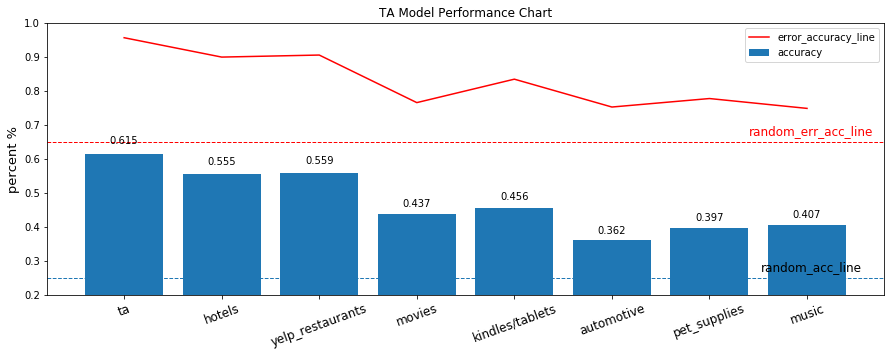

In [269]:
fig,ax = plt.subplots(1,figsize=(15,5))
ax.bar(dataset_counts,accuracy,label='accuracy')
ax.set_ylim(.2,1)
ax.axhline(.25,linestyle='--',linewidth=1)
ax.set_xticks(dataset_counts)
ax.set_xticklabels(datasets,rotation=20,fontsize=12)
ax.text(7.04,.27,'random_acc_line',color='black',horizontalalignment='center',fontsize=12)
ax.text(7.04,.67,'random_err_acc_line',color='red',horizontalalignment='center',fontsize=12)
ax.set_ylabel('percent %',fontsize=13)
ax.plot(dataset_counts,error_accuracy,label='error_accuracy_line',color='red')
ax.axhline(.65,linestyle='--',color='red',linewidth=1)
ax.set_title('TA Model Performance Chart')
# ax.set_yticks([])
for i in dataset_counts:
    ax.text(i,accuracy[i]+accuracy[i]*.05,'{}'.format(accuracy[i]),horizontalalignment='center')
ax.legend()
plt.show()

In [263]:
service_accuracies = accuracy[:3]
product_accuracies = accuracy[3:]

In [267]:
import scipy.stats as stats
t_score = stats.t.ppf(1-0.05, 4)

pa_mean = product_accuracies.mean()
sa_mean = service_accuracies.mean()
pa_var = product_accuracies.var()
sa_var = service_accuracies.var()
pa_sample_size = len(product_accuracies)
sa_sample_size = len(service_accuracies)
df = pa_sample_size + sa_sample_size -2

CI = stats.t.ppf(.95,5) * ((pa_var/(pa_sample_size-1))+(sa_var/(sa_sample_size-1)))**.5

In [268]:
CI

0.05100306411214209

In [ ]:
#       (Xhat1 - Xhat2) - (u1 - u2)
# t =  -----------------------------
#       Sqrt(s1^2/n1 + s2^2/n2)

In [253]:
(sa_mean-pa_mean)/((pa_var/pa_sample_size)+(sa_var/sa_sample_size))**(.5)

7.650594359887707

In [258]:
CI = (sa_mean-pa_mean) + stats.t.ppf(.95,5)*((pa_var/pa_sample_size)+(sa_var/sa_sample_size))**(.5)

In [260]:
CI

0.20786887172254057

In [246]:
accuracy[:2].mean()
accuracy[4:]

array([0.437, 0.456, 0.362, 0.397, 0.407])

In [ ]:
CiUpper = Xa-Xv + st.norm.ppf(.975,)*((SDv**2/Nv)+(SDa**2/Na))**.5

In [196]:
print(pa_mean)
print(sa_mean)
print(pa_var)
print(sa_var)
print(pa_sample_size)
print(sa_sample_size)

0.4055
0.5296000000000001
0.0011292500000000005
0.0039286400000000015
4
5


In [403]:
np.random.choice([1,2,3,10],size=10,replace=True)

array([ 1,  1,  3,  3,  2,  1,  1, 10,  2,  1])

In [430]:
def sample_mean_diff(series1,series2):
    return (np.sum(series1)/(len(series1)-1)) - (sum(series2)/(len(series2)-1))

def bootstrap(series1,series2,n):
    list_of_means = []
    for i in range(n):
        list_of_means.append(round(np.mean(np.random.choice(series1,size=len(series1),replace=True))\
                            -np.mean(np.random.choice(series2,size=len(series2),replace=True)),2))
    return list_of_means

def sample_mean(series):
    return np.sum(series) / (len(series) - 1)

sample_averages = bootstrap(service_accuracies,product_accuracies,500)

np.std(sample_averages)

0.021862945821640778

In [437]:
import seaborn as sns

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


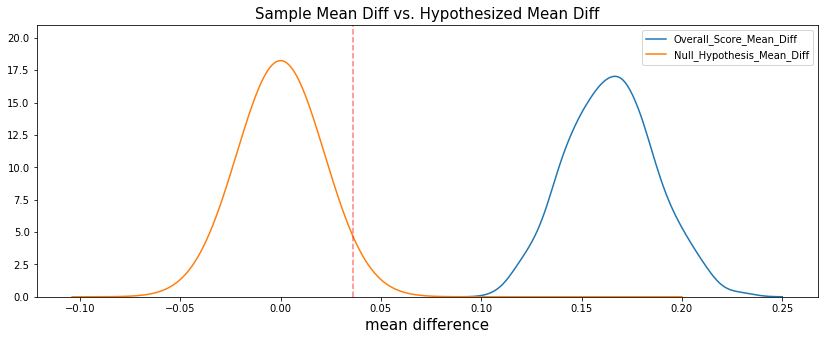

In [450]:
fig, ax = plt.subplots(1,figsize=(14,5))
normal_approx = stats.norm(0, np.std(sample_averages))
x1 = np.linspace(min(sample_averages),max(sample_averages),len(sample_averages))
# sns.distplot(sample_averages,bins=25,ax=ax,hist=False,label='Value Hotel-Airbnb Mean Diff')


# sns.distplot(value_averages,bins=25,ax=ax[1],label='Value_Score_Mean_Diff')
# sns.distplot(sample_averages,bins=25,ax=ax[1],label='Overall_Score_Mean_Diff',hist=False)
# ax[0].set_title('Value vs. Overall Airbnb Mean Score Difference')
sns.distplot(sample_averages,bins=25,ax=ax,label='Overall_Score_Mean_Diff',hist=False)
x = np.linspace(normal_approx.ppf(.000001), .2, num=1000)
ax.set_title('Sample Mean Diff vs. Hypothesized Mean Diff',fontsize=15)
ax.set_xlabel('mean difference',fontsize=15)
ax.set_ylim(0,21)
ax.plot(x,normal_approx.pdf(x),label='Null_Hypothesis_Mean_Diff')
# ax.axvline(x=normal_approx.ppf(.025), color = 'red',alpha=.5,label='.95 CI',linestyle='--')
ax.axvline(x=normal_approx.ppf(.95), color = 'red',alpha=.5,linestyle='--')
ax.legend()

In [408]:
np.random.choice(service_accuracies,size=len(service_accuracies),replace=True)

array([0.559, 0.615, 0.559])

In [411]:
def bootstrap(series1,series2,n):
    list_of_means = []
    for i in range(n):
        list_of_means.append(round(sample_mean(np.random.choice(series1,size=len(series1),replace=True))\
                            -sample_mean(np.random.choice(series2,size=len(series2),replace=True)),2))
    return list_of_means